In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import lightgbm as gbm
from lightgbm import LGBMClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv("gdrive/MyDrive/ImageClassificationCode/Light_GBM/data_imputed_iterative.csv", encoding = 'iso-8859-1')

In [ ]:
data.drop("Unnamed: 0", axis = 1, inplace = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82273 entries, 0 to 82272
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_Image                     82273 non-null  object 
 1   ID_Pacient                   82273 non-null  object 
 2   Eye                          82273 non-null  object 
 3   Retinopathy                  82273 non-null  int64  
 4   Age                          82273 non-null  float64
 5   Sex                          82273 non-null  object 
 6   HbA1c                        82273 non-null  float64
 7   Total Cholesterol            82273 non-null  float64
 8   LDL                          82273 non-null  float64
 9   HDL                          82273 non-null  float64
 10  Systolic Arterial Pressure   82273 non-null  float64
 11  Diastolic Arterial Pressure  82273 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 7.5+ MB


In [ ]:
data["Retinopathy"].value_counts() # checking classes

1    75782
2     4220
3     1737
4      307
5      227
Name: Retinopathy, dtype: int64

**1. DATA_TRANSFORMATION FUNCTION**

In [ ]:
def data_transformation(dataset, scaler):
  scaler = scaler
  data_scaled = scaler.fit_transform(dataset[["Age", "HbA1c", "Total Cholesterol", "LDL", "HDL", "Systolic Arterial Pressure", "Diastolic Arterial Pressure"]])
  encoder = OneHotEncoder(drop = "first", sparse=False)
  data_onehot = encoder.fit_transform(dataset[["Eye", "Sex"]])
  data = np.concatenate((data_scaled, data_onehot), axis = 1)
  features = dict(zip(("Age", "HbA1c", "Total Cholesterol", "LDL", "HDL", "Systolic Arterial Pressure", "Diastolic Arterial Pressure", "Eye", "Sex"), (i for i in range(1, 8))))
  return data, features


**2. PLOT CONFUSION MATRIX**

In [ ]:
classes = ('1: Normal','2: RD Lleu','3: RD Moderada','4: RD Severa','5: Proliferativa')
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return fig

**2. RAW MULTICLASS LIGHTGBM CLASSIFIER**

In [ ]:
def raw_lightgbm(dataset, scaler):
  X = data_transformation(dataset, scaler)[0]
  y = dataset["Retinopathy"].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  model = LGBMClassifier(objective = "multiclass") # multiclass.
  model.fit(X_train, y_train) # fit the model.
  y_pred = model.predict(X_test) # predict the results.
  accuracy = accuracy_score(y_pred, y_test) # check accuracy
  

  cm = confusion_matrix(y_test, y_pred) # get the confusion matrix.
  cm_matrix = pd.DataFrame(data=cm, columns=[i for i in range(1, 6)], 
                                 index=[i for i in range(1, 6)])
  

  report = classification_report(y_test, y_pred)

  return accuracy, cm, cm_matrix, report



  



In [ ]:
raw_model = raw_lightgbm(data, MinMaxScaler())

Normalized confusion matrix
[[1.         0.         0.         0.         0.        ]
 [0.95838288 0.04161712 0.         0.         0.        ]
 [0.88071066 0.00761421 0.0964467  0.         0.01522843]
 [0.61403509 0.         0.         0.38596491 0.        ]
 [0.42222222 0.         0.         0.         0.57777778]]


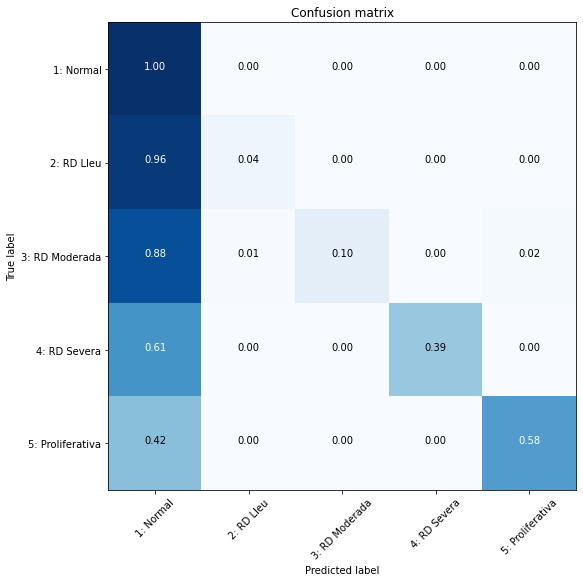

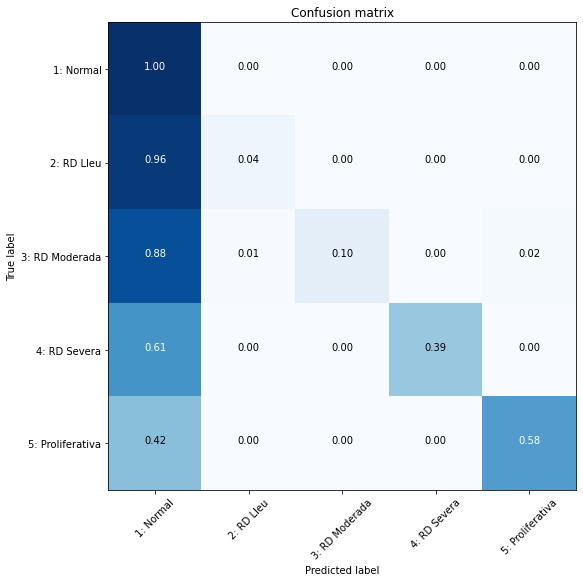

In [ ]:
plot_confusion_matrix(raw_model[1], classes, normalize = True, title='Confusion matrix', cmap=plt.cm.Blues)

In [ ]:
raw_model[0]

0.9261014889091461

In [ ]:
print(raw_model[3])

              precision    recall  f1-score   support

           1       0.93      1.00      0.96     15118
           2       0.92      0.04      0.08       841
           3       1.00      0.10      0.18       394
           4       1.00      0.39      0.56        57
           5       0.81      0.58      0.68        45

    accuracy                           0.93     16455
   macro avg       0.93      0.42      0.49     16455
weighted avg       0.93      0.93      0.90     16455



**3. HYPERPARAMETER TUNING**

3.1 Number of Trees

In [ ]:
data = pd.read_csv("gdrive/MyDrive/ImageClassificationCode/Light_GBM/data_imputed_iterative.csv", encoding = 'iso-8859-1')
data.drop("Unnamed: 0", axis = 1, inplace = True)

def tree_model(dataset, scaler, i):
  X = data_transformation(dataset, scaler)[0]
  y = dataset["Retinopathy"].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  model = LGBMClassifier(objective = "multiclass", n_estimators = i) # multiclass.
  model.fit(X_train, y_train) 
  y_pred = model.predict(X_test) # predict the results.
  accuracy = accuracy_score(y_pred, y_test) # check accuracy
  
  return accuracy


In [ ]:
models = dict()
trees = [10, 50, 100, 500, 1000, 5000, 7000, 9000]
for i in trees:
  models[str(i)] = tree_model(data, MinMaxScaler(), i)

In [ ]:
models

{'10': 0.918018839258584,
 '100': 0.9261014889091461,
 '1000': 0.962321482831966,
 '50': 0.9219082345791553,
 '500': 0.9488301428137345,
 '5000': 0.9722880583409298,
 '7000': 0.9723488301428137,
 '9000': 0.972956548161653}

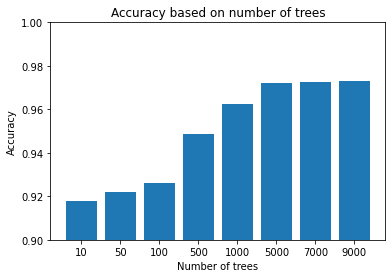

In [ ]:
plt.bar(models.keys(), models.values())
plt.ylim(0.9, 1.0)
plt.title("Accuracy based on number of trees")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.show()

3.2 Tree Depth

In [ ]:
data = pd.read_csv("gdrive/MyDrive/ImageClassificationCode/Light_GBM/data_imputed_iterative.csv", encoding = 'iso-8859-1')
data.drop("Unnamed: 0", axis = 1, inplace = True)

def depth_model(dataset, scaler, i):
  X = data_transformation(dataset, scaler)[0]
  y = dataset["Retinopathy"].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  model = LGBMClassifier(objective = "multiclass", max_depth = i, num_leaves = 2**i) # multiclass.
  model.fit(X_train, y_train) 
  y_pred = model.predict(X_test) # predict the results.
  accuracy = accuracy_score(y_pred, y_test) # check accuracy
  
  return accuracy

In [ ]:
models = dict()
depth = [i for i in range (1, 18)]
for i in depth:
  models[str(i)] = depth_model(data, MinMaxScaler(), i)

In [ ]:
models

{'1': 0.9187481008811911,
 '10': 0.9468854451534487,
 '11': 0.9512610148890914,
 '12': 0.9558796718322699,
 '13': 0.9604983287754482,
 '14': 0.9629292008508052,
 '15': 0.9657247037374658,
 '16': 0.9676694013977515,
 '17': 0.9677301731996354,
 '2': 0.9188088726830751,
 '3': 0.9190519598906107,
 '4': 0.9201458523245214,
 '5': 0.9218474627772714,
 '6': 0.9251899118808873,
 '7': 0.9290793072014585,
 '8': 0.9354603463992708,
 '9': 0.941841385597083}

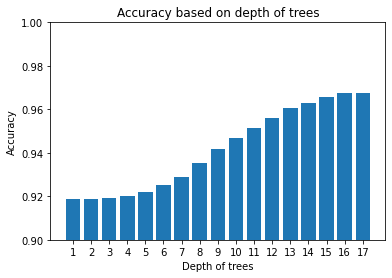

In [ ]:
plt.bar(models.keys(), models.values())
plt.ylim(0.9, 1.0)
plt.title("Accuracy based on depth of trees")
plt.xlabel("Depth of trees")
plt.ylabel("Accuracy")
plt.show()

3.3 Learning Rate

In [ ]:
data = pd.read_csv("gdrive/MyDrive/ImageClassificationCode/Light_GBM/data_imputed_iterative.csv", encoding = 'iso-8859-1')
data.drop("Unnamed: 0", axis = 1, inplace = True)

def lr_model(dataset, scaler, i):
  X = data_transformation(dataset, scaler)[0]
  y = dataset["Retinopathy"].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  model = LGBMClassifier(objective = "multiclass", learning_rate = i) # multiclass.
  model.fit(X_train, y_train) 
  y_pred = model.predict(X_test) # predict the results.
  accuracy = accuracy_score(y_pred, y_test) # check accuracy
  
  return accuracy

In [ ]:
models = dict()
lr = [i for i in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]]
for i in lr:
  models[str(i)] = lr_model(data, MinMaxScaler(), i)

In [ ]:
models

{'0.0001': 0.9187481008811911,
 '0.001': 0.9187481008811911,
 '0.01': 0.9187481008811911,
 '0.1': 0.9261014889091461,
 '0.2': 0.9354603463992708,
 '0.3': 0.9154056517775752,
 '0.4': 0.9099969614099058,
 '0.5': 0.9084168945609238,
 '1.0': 0.8926769978729869}

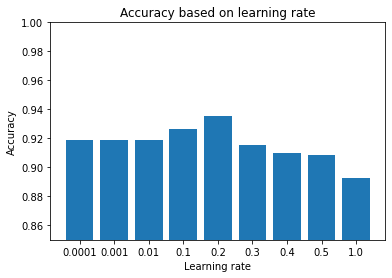

In [ ]:
plt.bar(models.keys(), models.values())
plt.ylim(0.85, 1.0)
plt.title("Accuracy based on learning rate")
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.show()

3.4 Boosting Type

In [ ]:
data = pd.read_csv("gdrive/MyDrive/ImageClassificationCode/Light_GBM/data_imputed_iterative.csv", encoding = 'iso-8859-1')
data.drop("Unnamed: 0", axis = 1, inplace = True)

def boosting_model(dataset, scaler, i):
  X = data_transformation(dataset, scaler)[0]
  y = dataset["Retinopathy"].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  model = LGBMClassifier(objective = "multiclass", boosting_type = i) # multiclass.
  model.fit(X_train, y_train) 
  y_pred = model.predict(X_test) # predict the results.
  accuracy = accuracy_score(y_pred, y_test) # check accuracy
  
  return accuracy

In [ ]:
models = dict()
boosting_type = ["gbdt", "dart", "goss"]
for i in boosting_type:
  models[str(i)] = boosting_model(data, MinMaxScaler(), i)

In [ ]:
models

{'dart': 0.9211182011546643,
 'gbdt': 0.9261014889091461,
 'goss': 0.9272561531449407}

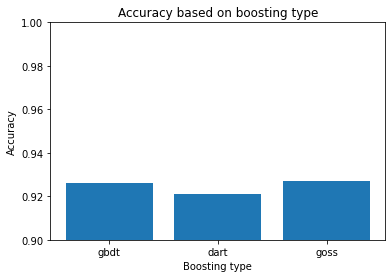

In [ ]:
plt.bar(models.keys(), models.values())
plt.ylim(0.9, 1.0)
plt.title("Accuracy based on boosting type")
plt.xlabel("Boosting type")
plt.ylabel("Accuracy")
plt.show()

**4. CLASS IMBALANCE**

In [ ]:
data["Retinopathy"].value_counts()

1    75782
2     4220
3     1737
4      307
5      227
Name: Retinopathy, dtype: int64

In [ ]:
len(data.values)

82273

In [ ]:
keys = [i-1 for i in data["Retinopathy"].unique()]
values = [i/len(data.values) for i in [j for j in data["Retinopathy"].value_counts()]]
values = [values[-1]/i for i in values]

In [ ]:
weights = dict(zip(keys, values))

In [ ]:
weights

{0: 0.0029954342719907103,
 1: 0.053791469194312796,
 2: 0.13068508923431205,
 3: 0.739413680781759,
 4: 1.0}

In [ ]:
data = pd.read_csv("gdrive/MyDrive/ImageClassificationCode/Light_GBM/data_imputed_iterative.csv", encoding = 'iso-8859-1')
data.drop("Unnamed: 0", axis = 1, inplace = True)


def raw_lightgbm_imbalance(dataset, scaler, weights):
  X = data_transformation(dataset, scaler)[0]
  y = dataset["Retinopathy"].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  model = LGBMClassifier(objective = "multiclass", class_weight = weights) # multiclass.
  model.fit(X_train, y_train) # fit the model.
  y_pred = model.predict(X_test) # predict the results.
  accuracy = accuracy_score(y_pred, y_test) # check accuracy
  

  cm = confusion_matrix(y_test, y_pred) # get the confusion matrix.
  cm_matrix = pd.DataFrame(data=cm, columns=[i for i in range(1, 6)], 
                                 index=[i for i in range(1, 6)])
  

  report = classification_report(y_test, y_pred)

  return accuracy, cm, cm_matrix, report

In [ ]:
raw_model_imbalance = raw_lightgbm_imbalance(data, MinMaxScaler(), weights)

Normalized confusion matrix
[[0.69671914 0.17297262 0.0816907  0.03790184 0.0107157 ]
 [0.26159334 0.60879905 0.07728894 0.04756243 0.00475624]
 [0.15482234 0.11167513 0.64467005 0.06091371 0.02791878]
 [0.05263158 0.         0.07017544 0.85964912 0.01754386]
 [0.04444444 0.15555556 0.06666667 0.06666667 0.66666667]]


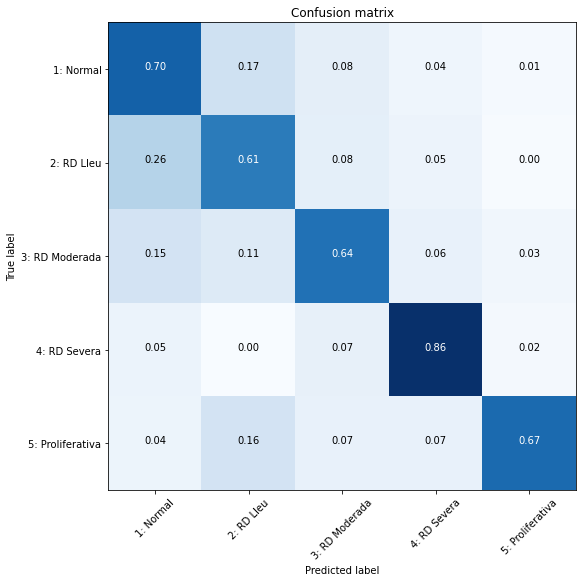

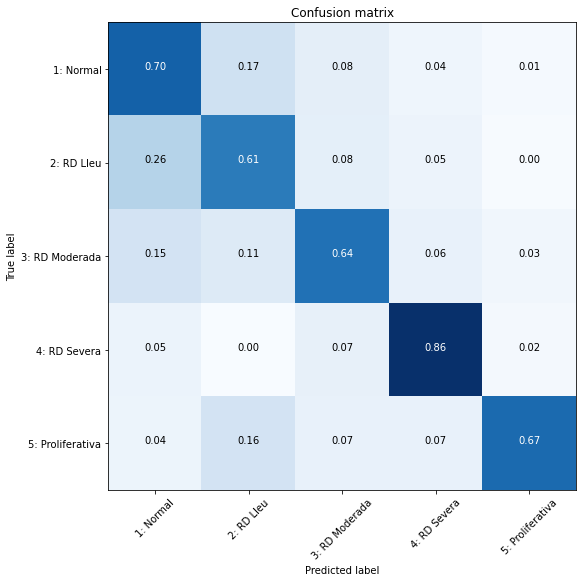

In [ ]:
plot_confusion_matrix(raw_model_imbalance[1], classes, normalize = True, title='Confusion matrix', cmap=plt.cm.Blues)

In [ ]:
raw_model_imbalance[0]

0.6914615618353084

In [ ]:
print(raw_model_imbalance[3])

              precision    recall  f1-score   support

           1       0.97      0.70      0.81     15118
           2       0.16      0.61      0.25       841
           3       0.16      0.64      0.26       394
           4       0.07      0.86      0.13        57
           5       0.14      0.67      0.24        45

    accuracy                           0.69     16455
   macro avg       0.30      0.70      0.34     16455
weighted avg       0.91      0.69      0.77     16455



**5. WRAPPED**

In [ ]:
data = pd.read_csv("gdrive/MyDrive/ImageClassificationCode/Light_GBM/data_imputed_iterative.csv", encoding = 'iso-8859-1')
data.drop("Unnamed: 0", axis = 1, inplace = True)


def raw_lightgbm_final(dataset, scaler, weights, estimators, depth, lr, boost):
  X = data_transformation(dataset, scaler)[0]
  y = dataset["Retinopathy"].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  model = LGBMClassifier(objective = "multiclass", class_weight = weights, n_estimators = estimators, max_depth = depth, num_leaves = 2**depth, learning_rate = lr, boosting_type = boost) # multiclass.
  model.fit(X_train, y_train) # fit the model.
  y_pred = model.predict(X_test) # predict the results.
  accuracy = accuracy_score(y_pred, y_test) # check accuracy
  

  cm = confusion_matrix(y_test, y_pred) # get the confusion matrix.
  cm_matrix = pd.DataFrame(data=cm, columns=[i for i in range(1, 6)], 
                                  index=[i for i in range(1, 6)])
  

  report = classification_report(y_test, y_pred)

  return accuracy, cm, cm_matrix, report

In [ ]:
raw_lightgbm_final = raw_lightgbm_final(data, MinMaxScaler(), weights, 1000, 15, 0.2, "goss")

Normalized confusion matrix
[[9.77444106e-01 1.36922873e-02 5.82087578e-03 2.24897473e-03
  7.93755788e-04]
 [2.21165279e-01 7.62187872e-01 1.18906064e-02 3.56718193e-03
  1.18906064e-03]
 [1.19289340e-01 3.29949239e-02 8.37563452e-01 0.00000000e+00
  1.01522843e-02]
 [1.57894737e-01 1.75438596e-02 3.50877193e-02 7.71929825e-01
  1.75438596e-02]
 [2.88888889e-01 0.00000000e+00 2.22222222e-02 4.44444444e-02
  6.44444444e-01]]


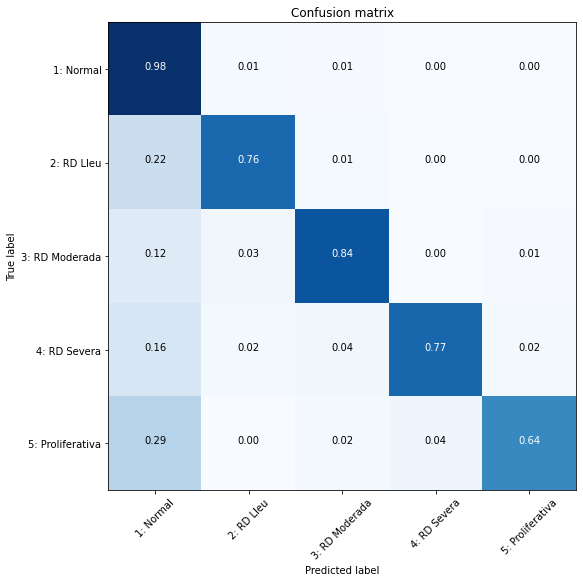

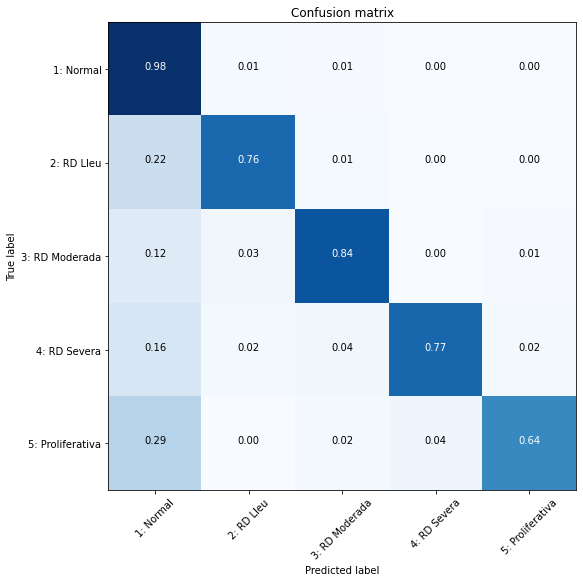

In [ ]:
plot_confusion_matrix(raw_lightgbm_final[1], classes, normalize = True, title='Confusion matrix', cmap=plt.cm.Blues)

In [ ]:
print(raw_lightgbm_final[3])

              precision    recall  f1-score   support

           1       0.98      0.98      0.98     15118
           2       0.74      0.76      0.75       841
           3       0.77      0.84      0.80       394
           4       0.53      0.77      0.63        57
           5       0.62      0.64      0.63        45

    accuracy                           0.96     16455
   macro avg       0.73      0.80      0.76     16455
weighted avg       0.96      0.96      0.96     16455



In [ ]:
raw_lightgbm_final_2 = raw_lightgbm_final(data, MinMaxScaler(), weights, 1250, 14, 0.2, "goss")

Normalized confusion matrix
[[9.77113375e-01 1.38907263e-02 5.95316841e-03 2.24897473e-03
  7.93755788e-04]
 [2.24732461e-01 7.58620690e-01 1.18906064e-02 3.56718193e-03
  1.18906064e-03]
 [1.14213198e-01 3.55329949e-02 8.40101523e-01 0.00000000e+00
  1.01522843e-02]
 [1.40350877e-01 1.75438596e-02 3.50877193e-02 7.89473684e-01
  1.75438596e-02]
 [2.88888889e-01 0.00000000e+00 2.22222222e-02 4.44444444e-02
  6.44444444e-01]]


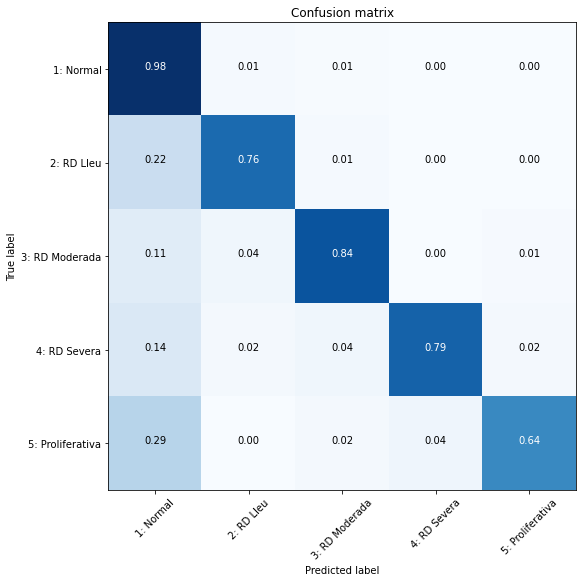

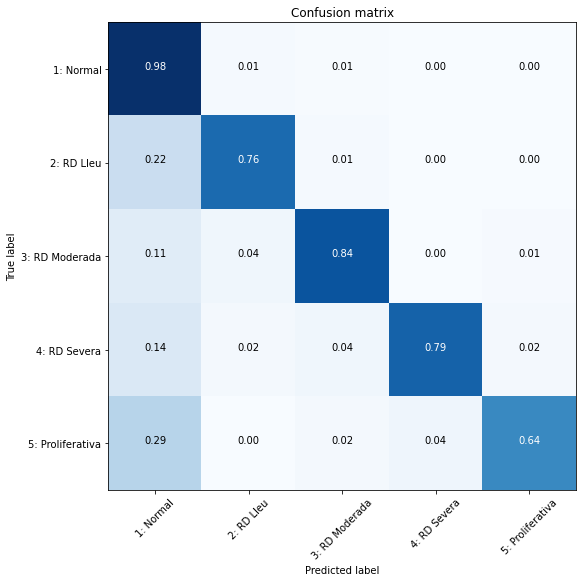

In [ ]:
plot_confusion_matrix(raw_lightgbm_final_2[1], classes, normalize = True, title='Confusion matrix', cmap=plt.cm.Blues)

In [ ]:
print(raw_lightgbm_final_2[3])

              precision    recall  f1-score   support

           1       0.98      0.98      0.98     15118
           2       0.74      0.76      0.75       841
           3       0.76      0.84      0.80       394
           4       0.54      0.79      0.64        57
           5       0.62      0.64      0.63        45

    accuracy                           0.96     16455
   macro avg       0.73      0.80      0.76     16455
weighted avg       0.96      0.96      0.96     16455



In [ ]:
raw_lightgbm_final_3 = raw_lightgbm_final(data, MinMaxScaler(), weights, 2000, 14, 0.2, "goss")

Normalized confusion matrix
[[9.77113375e-01 1.39568726e-02 5.88702209e-03 2.24897473e-03
  7.93755788e-04]
 [2.25921522e-01 7.57431629e-01 1.18906064e-02 3.56718193e-03
  1.18906064e-03]
 [1.16751269e-01 3.55329949e-02 8.37563452e-01 0.00000000e+00
  1.01522843e-02]
 [1.40350877e-01 1.75438596e-02 3.50877193e-02 7.89473684e-01
  1.75438596e-02]
 [2.88888889e-01 0.00000000e+00 2.22222222e-02 4.44444444e-02
  6.44444444e-01]]


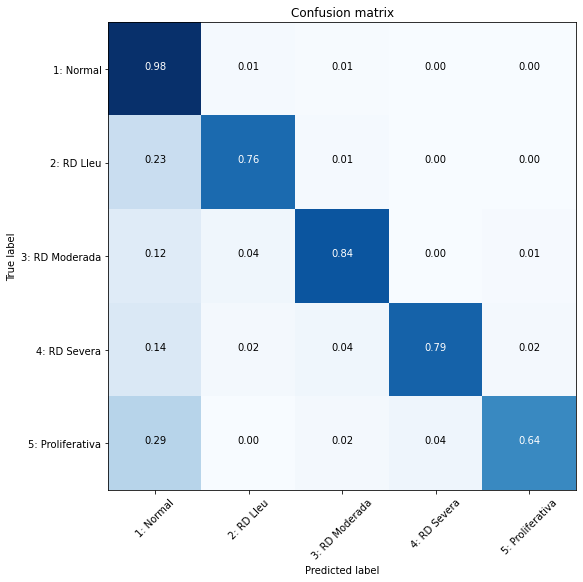

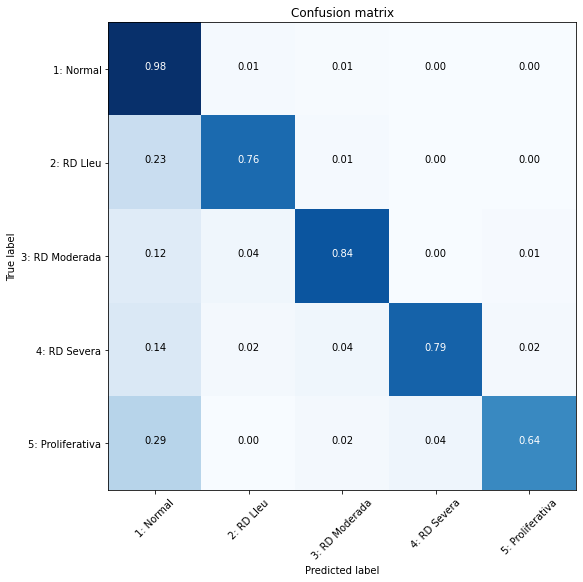

In [ ]:
plot_confusion_matrix(raw_lightgbm_final_3[1], classes, normalize = True, title='Confusion matrix', cmap=plt.cm.Blues)

In [ ]:
print(raw_lightgbm_final_3[3])

              precision    recall  f1-score   support

           1       0.98      0.98      0.98     15118
           2       0.74      0.76      0.75       841
           3       0.76      0.84      0.80       394
           4       0.54      0.79      0.64        57
           5       0.62      0.64      0.63        45

    accuracy                           0.96     16455
   macro avg       0.73      0.80      0.76     16455
weighted avg       0.96      0.96      0.96     16455

